# INFO 2950 Final Project

**Note:**
None of our group members is a native English speaker.


## Introduction
#### Background Information:
Hate crime is a crime motivated by bias against ethnicity/race/ancestry, religion, sexual orientation, disability, gender, and gender identity. Hate crime against gender minorities (e.g. women) and racial minorities (e.g. anti-Black, anti-Hispanic, anti-Asian) has been a long-standing problem in the US; in recent decades when gender identity and sexual orientation minorities (trans, LGBTQ+) are increasingly exposed to the public on mass media, there is also a rising trend of news reports on hate crime incidents against those groups; during Covid periods, reported anti-Asian hate crimes were especially on a rise. 

Not every state/region of the US has the same pattern of hate crimes though – the number and kinds of incidents vary by state. Therefore, we are interested in exploring what factors are related to and may predict hate crime incidents in the US states. Specifically, we expect that state crimes are linked to social factors and the economic status of the state, so we choose to include data on the following state-dependent factors: GDP, population, marriage rate, and education level (bachelor’s degree or higher rate). Besides, according to temperature aggression theory, high temperatures increase violence and aggression, so we think that temperature might also be a predictor of hate crimes, and thus we include data on state annual temperature. Moreover, the Covid-19 pandemic happened over the past two years has brought a lot of social- and policy-level changes, which affect interpersonal social distances, relationships, and biases. Therefore, Covid may also have an impact on the changes in number of hate crimes, and thus we differentiate the years before 2020 as pre-Covid from the year 2020 as Covid to look at Covid effects.

#### Data Sources:
- Hate Crime Incidents by State: FBI Government https://www.fbi.gov/how-we-can-help-you/need-an-fbi-service-or-more-information/ucr/publications#Hate-Crime%20Statistics (year 2006-2019) and https://crime-data-explorer.fr.cloud.gov/pages/downloads (year 2020). 
- State GDP: Bureau of Economic Analysis
https://www.bea.gov/data/gdp/gdp-state
- State Population: United Stated Census Bureau  ​https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/state/totals/
- Temperature: National Centers for Environmental Information
https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/50/tavg/ann/12/2006-2020?base_prd=true&begbaseyear=1925&endbaseyear=2000
- State Marriage Rate: Centers for Disease Control and Prevention (CDC)
https://www.cdc.gov/nchs/data/dvs/state-marriage-rates-90-95-99-20.pdf
- State Education Rate: Fred Economic Data
https://fred.stlouisfed.org/release/tables?rid=330&eid=391444&od=2006-01-01


#### Research Questions:
1. Explore the socioeconomic and environmental features that best predict hate crime incidents in the United States.
2. Explore whether Covid-19 affects the prediction of hate crime incidents in the United States.

#### Summary of Findings:
**Hypothesis 1** 

- Regarding the socioeconomic and environmental features that we included, we found that when the inputs are a combination of **GDP, temperature, education rate, and marriage rate**, the model best predicts hate crime incidents. 

**Hypothesis 2**

- Regarding whether Covid affects hate crime incident prdictions, we found that **Covid status does NOT help** improve the model in predicitng hate crime incidents, which means that Covid does not have significant effect on hate crime incidents. 



In [73]:
import numpy as np
from numpy import sqrt, mean, absolute
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression

## Data Description
#### Motivation:
This dataset was created to study how the socioeconomic and environmental factors (i.e. GDP, population, marriage rate, bachelor’s degree or higher rate, temperature, Covid-19) are related to hate crimes and how well they predict the number of hate crime incidents. No previous hate crime datasets specifically contain these features and compare data from years before the Covid-19 and during the Covid-19.

This dataset is created by Hao Chen, Chang Chen, and Jane (Yuqing) Guo, on behalf of the course INFO 2950: Introduction to Data Science at Cornell University.

#### Collection Process:
All data was directly observable. They were collected by the government and we obtained them from either the official or institutional websites. 

The hate crime incidents, marriage rate, and education rate date  were downloaded as xsl. files, so we reformatted them using Microsoft Excel and converted them to csv files. All other data were downloaded as csv. files.

#### Uses:
This dataset has not been used for any other tasks. It could be used to provide state governments and lawmakers with justification for certain legislation, supply the media with credible information, and help researchers in determining trends in hate crimes. It should not be used to provide hate crime offenders with justification for their crime commitments.

While education rate in our dataset refers to the rate of bachelor’s degree or higher within the state population, there are many other ways to define education rates, such as the rate of the population that obtains high school or higher degrees. Different definitions might impact future uses, and future users should be clear about the specific feature definitions in this dataset.

#### Data Cleaning/Preprocessing: Please see markdown cells below for specific steps.
The original data was saved in this folder: https://drive.google.com/drive/folders/1i_sfrSfdm2_F-V70Ajh4QbueJqV1Y29M?usp=sharing

**Data Cleaning/Preprocessing**
1. Hate crime incidents
   
   *Clean Excel format* 
   - Delete titles, merged cells, and footers
   - Renamed columns and indexes to standardize across all years
   - Replace NaNs with zeros
   
   *Process* 
   - Add an [Incidents] column: summing incidents of all categories of that row (state)
   - Add a [Year] column
   - Drop all other columns (specific incident categories) except for [State]

In [74]:
# Import annual hate crime incidents df
years = np.linspace(2006, 2020, 15, dtype=int).tolist()
offenses =[]
for y in years:
    n = y - 2006
    offenses_path='./offenses_csv/%s.csv'%(y)
    offenses.append(pd.read_csv(offenses_path, thousands=','))
    
    # Add Year column
    offenses[n]['Year'] = y

# Combine all years' incidents data
df_off = pd.concat(offenses)

# Drop details because we only care about total
df_off = df_off[df_off['Agency type'] == 'Total']
df_off = df_off.drop(columns=['Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Agency name', 'Agency type',
'Unnamed: 3', 'Unnamed: 9', 'Agency unit', 'Population1', '1st\r\nquarter', '2nd\r\nquarter', '3rd\r\nquarter', '4th\r\nquarter'])

# Replace NaNs with zeros
df_off = df_off.replace(np.nan,0)

# Replace exisiting str zero with float
cat_list=['Race', 'Religion', 'Sexual_orientation', 'Ethnicity', 'Disability', 'Gender', 'Gender_identity', 'Race/Ethnicity/Ancestry']
df_off[cat_list] = df_off[cat_list].astype(int)

# Add up total incidents
df_off['Incidents'] = 0
for c in cat_list:
    df_off['Incidents'] += df_off[c]

# Get rid of categories because we only care about total
df_off = df_off.drop(columns=cat_list)

# Clean State format
df_off['State'] = df_off['State'].str.title()
df_off['Year'] = df_off['Year'].astype(str)
df_off = df_off.reset_index(drop=True)
df_off.to_csv('incidents.csv')
# df_off

2. Population
   
   *Clean* 
   - Combine data from raw data table 2001-2010 and table 2010-2020
   
   *Process* 
   - Select only total population
   - Drop subcatrgories
   - Melt the wide dateframe to a tidy dataframe through [Year] (each rows represents one year one state)

In [75]:
pop1 = pd.read_csv('./pop1.csv', thousands=',')

# Turn wide df to tidy
pop1 = pd.melt(pop1, id_vars=['State'], value_vars=pop1.columns[1:], var_name='Year', value_name='Population')
# pop1

In [76]:
pop2 = pd.read_csv('./pop2.csv', thousands=',')

# Select totol by setting all categorical inputs to zero
col =['SEX', 'ORIGIN', 'RACE', 'AGEGRP']
for c in col:
    pop2 = pop2[pop2[c] == 0]

pop2 = pop2.drop(columns=col)
# Turn wide df to tidy
pop2 = pd.melt(pop2, id_vars=['State'], value_vars=pop2.columns[1:], var_name='Year', value_name='Population')
# pop2

In [77]:
# Combine population data (2010-2020) and (2000-2009)
df_pop = pd.concat([pop2, pop1])
df_pop.to_csv('population.csv')
# df_pop

3. GDP

   *Process* 
   - melt the wide dataframe to a tidy dataframe through [Year](each rows represents one year one state)

In [78]:
df_gdp = pd.read_csv('./raw_gdp.csv', thousands=',')

# Trun wide df to tidy
df_gdp = pd.melt(df_gdp, id_vars=['State'], value_vars=df_gdp.columns[1:], var_name='Year', value_name='GDP')
df_gdp.to_csv('gdp.csv')
# df_gdp

4. Average temperature
   
   *Clean* 
   - Change column names to the same ones as in other dataframes above
   
   *Process*
   - Add [State] and [Year] columns
   - Drop other columns
   - Combine data from all states

In [79]:
# read all csv in temperature folder
path = './avg_temp'
csv_files = glob.glob(path + '/*.csv')

dfs = []
for f in csv_files:
    df = pd.read_csv(f)

    # Get State column
    parts = f.split('/')
    part = parts[2].split('.')
    df['State'] = part[0]

    # Formatting 
    df['Temperature'] = df['Value']
    df['Year'] = (df['Date']/100).astype(int).astype(str)
    df = df.drop(columns=['Date', 'Value', 'Anomaly'])

    # Combine all avg_temp df
    dfs.append(df)

df_temp = pd.concat(dfs).reset_index(drop=True)
df_temp.to_csv('temperature.csv')
# df_temp

5. Marriage rate
   
   *Clean* 
   - Change column names to the same ones as in other dataframes above
   
   *Process*
   - Replace missing data with linear regression prediction results
   - melt the wide dataframe to a tidy dataframe through [Year](each rows represents one year one state)

In [80]:
df_marr = pd.read_csv('./marr.csv', thousands=',')
df_marr['State'] = df_marr['Unnamed: 0']
df_marr = df_marr.drop(columns=['Unnamed: 0', 'Unnamed: 25'])
df_marr = df_marr.replace('---',0)
df_marr = pd.melt(df_marr, id_vars=['State'], value_vars=df_marr.columns[:-1], var_name='Year', value_name='Marriage_Rate')

def replace(s):
    df = df_marr.loc[df_marr['State']==s]
    df_ = df.reset_index(drop=True)
    reg = LinearRegression().fit(df[['Year']], df['Marriage_Rate'])
    pred = reg.predict(df[['Year']])
    big_l = df[df['Marriage_Rate']==0].index.to_list()
    small_l = df_[df_['Marriage_Rate']==0].index.to_list()

    for i, l in enumerate(big_l):
        df_marr.loc[l, 'Marriage_Rate'] = pred[small_l[i]]

states = ['Georgia', 'Louisiana', 'Oklahoma']
for s in states: replace(s)

df_marr['Year'] = df_marr['Year'].astype(str)
df_marr['Marriage_Rate'] = df_marr['Marriage_Rate'].astype(float)
df_marr.to_csv('marriage.csv')

6. Education rate
   
   *Clean* 
   - Change column names to the same ones as in other dataframes above
   
   *Process*
   - melt the wide dataframe to a tidy dataframe through [State](each rows represents one year one state)

In [81]:
df_edu = pd.read_csv('./edu.csv', thousands=',')
df_edu = pd.melt(df_edu, id_vars=['Year'], value_vars=df_edu.columns[1:], var_name='State', value_name='Education_Rate')
df_edu['Year'] = df_edu['Year'].astype(str)
# df_edu

Model DataFrame

- Combine four variables above
- *Transformation* 
    - change population and GDP to log scale
    - add binary covid indicator

In [82]:
# Combine all input features and the output
df = df_pop.merge(df_gdp, on=['State', 'Year'])
df = df.merge(df_off, on=['State', 'Year'])
df = df.merge(df_temp, on=['State', 'Year'])
df = df.merge(df_marr, on=['State', 'Year'])
df = df.merge(df_edu, on=['State', 'Year'])
df['Year'] = df['Year'].astype(int)

# Add covid indicator (binary)
df['Is_Covid'] = np.where(df['Year']==2020, 1, 0)
df.to_csv('model.csv')
df

,State,Year,Population,GDP,Incidents,Temperature,Marriage_Rate,Education_Rate,Is_Covid
0,Alabama,2006,4628981,187270.8,1,64.2,9.2,26.9,0
1,Alaska,2006,675302,49190.2,6,26.4,8.2,21.1,0
2,Arizona,2006,6029141,274179.4,149,61.1,6.5,18.2,0
3,Arkansas,2006,2821761,108460.6,113,62.0,12.4,25.5,0
4,California,2006,36021202,2002437.4,1297,58.6,6.3,29.0,0
...,...,...,...,...,...,...,...,...,...
722,Virginia,2020,8590563,478909.3,170,57.4,5.3,42.1,1
723,Washington,2020,7693612,538856.1,462,48.1,4.8,38.4,1
724,West Virginia,2020,1784787,70444.2,54,54.0,5.6,31.8,1
725,Wisconsin,2020,5832655,293104.9,72,44.8,4.5,23.1,1


## Data Description:

#### Composition:
**Instances:**
</br> Each instance represents a US state per year. There are 49 states (Hawaii not included), and each state has data from 2006 to 2020 (15 years). However, for certain years a few states did not have recorded hate crime incidents, so they are missing in the raw data, and there are a total of 8 missing instances (Alabama misses data in year 2018, 2019; New Jersey misses data in year 2012; Mississippi misses data in year 2006, 2007, 2015; Wyoming misses data in year 2014, 2018). In total, there are 49 * 15 - 8 = 727 rows.

The dataset is a sample of hate crime incidents of all states from all years documented, and the larger set is data that contains both reported and unreported hate crime incidents of 50 states, from 1996, the earliest year related data was collected, to 2020 (the latest data collected). Due to the nature of the dataset, only data on reported incidents could be collected. Since how hate crime data was collected prior to 2006 is different from that post 2006, and raw data of education (bachelor’s degree or higher) by state is only accessible from years beginning 2006, our dataset contains only data from year 2006 to 2020. Since the raw data of temperature does not include Hawaii as a state, our dataset does not contain data of Hawaii.

Each instance consists of hate crime incidents, year, population, GDP, annual temperature, marriage rate, education rate, and is_Covid. While is_Covid is a binary variable, all other features contain numeric values.

The marriage rate data contains missing values for Georgia in 2013, 2014; Louisiana in 2006 and Oklahoma in 2000 - 2003. For each State above, we ran a Linear Regression model (where X= ‘Year’, and y = ‘Marriage rate’) and replaced these missing values with predicted results.

The individual instances are largely unrelated, except for that they are all geographical data and are collected from the same sources.


**Dataset:**
</br>Our dataset combines data from the following sources: Federal Bureau Investigation (FBI), US Census Bureau, Bureau of Economic Analysis (BEA), National Centers for Environmental Information (NCEI), Centers for Disease Control and Prevention (CDC), and Fred Economic Data wepages. All sources allow public access. Specifically, the FBI, NCEI, US Census Bureau, BEA, and CDC are official government websites – they keep records of all their published data and official archival versions of the complete raw dataset, so these would exist and remain constant over time. Fred Economic Data is a source for economic data and is built for economic research, so its resources will exist and remain constant to a large extent.

To note, for the data presented in the raw population dataset, since the census was conducted once every ten years, only data in year 2010 and 2020 were actual data – all other data in years between 2000 and 2010, 2010 and 2020 were estimated data.

The dataset does not contain data that might be considered confidential, offensive, insulting, or threatening. The dataset is not sensitive and does not identify any subpopulation or individual.


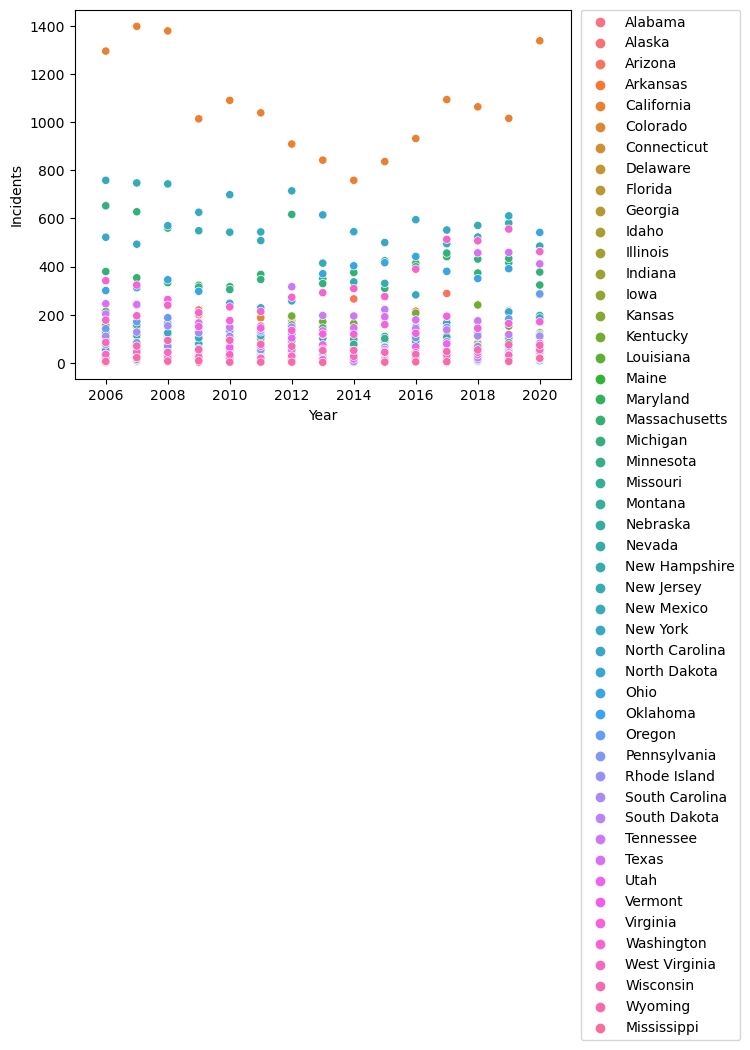

In [83]:
# Plot scatter plot Incidents X Year
ax = sns.scatterplot(data=df, x='Year', y='Incidents', hue='State')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlim(2005,2021)
plt.show()

### Preregistration statements
**Hypothesis 1**

Null: None of the predictor variables is useful in terms of predicting the number of state-wise hate crime incidents.
- β(log GDP) = β(log population) = β(temperature) = β(marriage rate) = β(education rate) = 0 in all combinations of inputs.

Alternative: At least one of the predictor variables is useful in terms of predicting the number of state-wise hate crime incidents.
- βi ≠ 0 (for i = log GDP, log population, temperature, marriage rate, education rate) in at least one combination of inputs.

**Hypothesis 2**

Null: On top of the model above, before Covid or after doesn’t affect the number of state-wise hate crime incidents.
- β (is_covid)  = 0  

Alternative: Incidents of state-wise hate crimes increase with the presence of Covid.
- β (is_covid) ≠ 0

### Data analysis
First, we split our data into 75% training set and 25% testing set. 

In [84]:
train, test= train_test_split(df, test_size=0.25)

**Prerequisites for Multivariable Linear Regression**

For Hypothesis 1, we have selected GDP, temperature, population, marriage rate, and education rate of the fifty states as potential candidates for building our multilinear regression model. Before conducting any regression, we used the training set to check the feasibility of multivariable linear regression of among our predictor variables. Specifically:
- Linearity: There's a linear relationship between predictors and response variables.
- Homoscedasticity: The variance of the residuals is constant.
- Multicollinearity: There should not be any multicollinearity in the data. The predictors should not be correlated with each other.

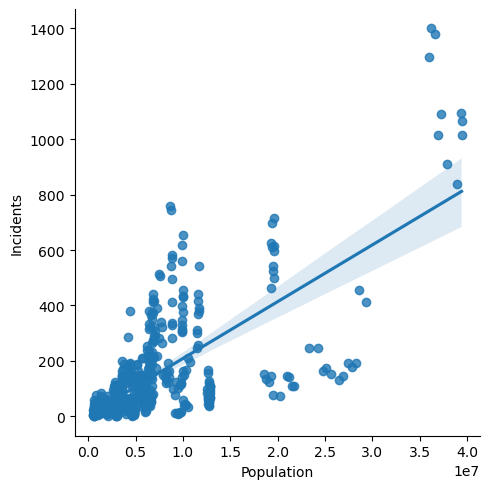

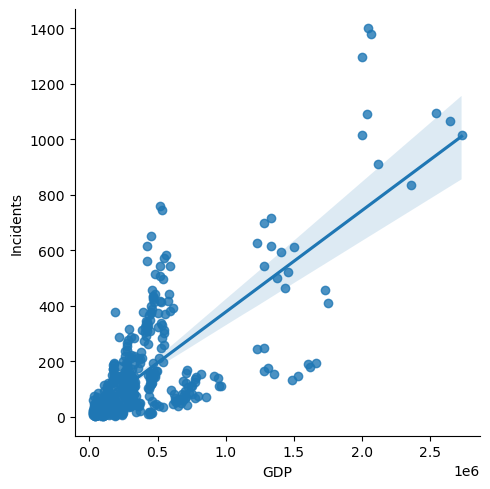

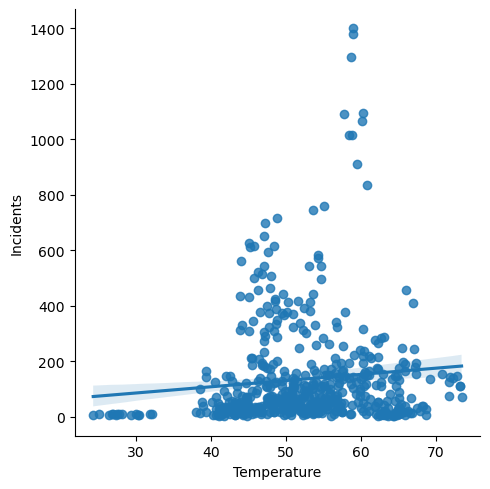

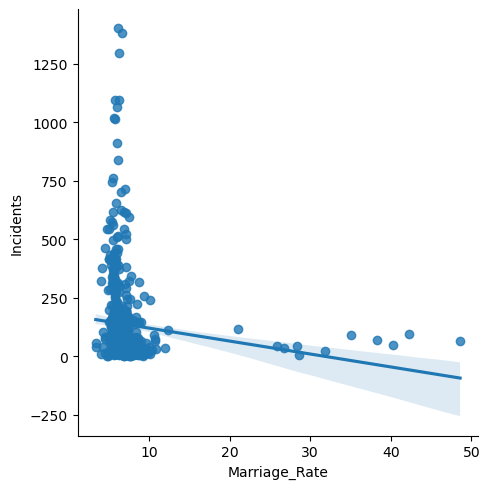

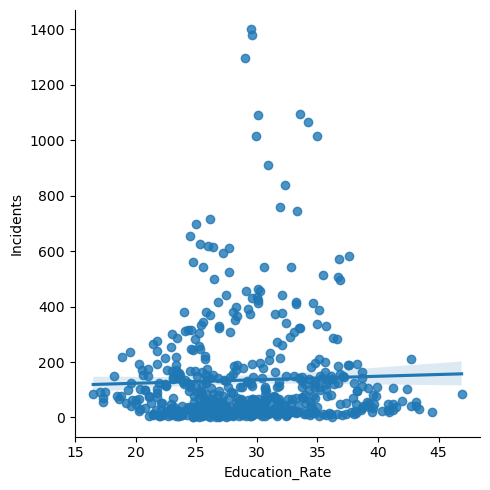

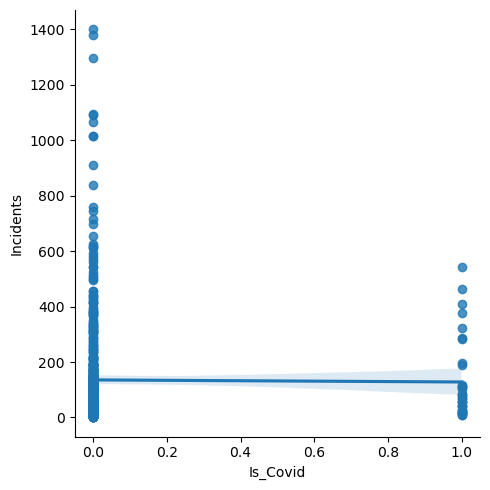

In [85]:
var = train.columns[[2,3,5,6,7,8]]
for v in var:
    sns.lmplot(data=train, x=v, y='Incidents')
    plt.show()

In [86]:
# Log transformation
df['Log_Population'] = np.log(df['Population'])
df['Log_GDP'] = np.log(df['GDP'])
train, test= train_test_split(df, test_size=0.25, random_state=42)
df

,State,Year,Population,GDP,Incidents,Temperature,Marriage_Rate,Education_Rate,Is_Covid,Log_Population,Log_GDP
0,Alabama,2006,4628981,187270.8,1,64.2,9.2,26.9,0,15.347847,12.140311
1,Alaska,2006,675302,49190.2,6,26.4,8.2,21.1,0,13.422915,10.803450
2,Arizona,2006,6029141,274179.4,149,61.1,6.5,18.2,0,15.612115,12.521538
3,Arkansas,2006,2821761,108460.6,113,62.0,12.4,25.5,0,14.852872,11.594142
4,California,2006,36021202,2002437.4,1297,58.6,6.3,29.0,0,17.399618,14.509876
...,...,...,...,...,...,...,...,...,...,...,...
722,Virginia,2020,8590563,478909.3,170,57.4,5.3,42.1,1,15.966175,13.079267
723,Washington,2020,7693612,538856.1,462,48.1,4.8,38.4,1,15.855901,13.197204
724,West Virginia,2020,1784787,70444.2,54,54.0,5.6,31.8,1,14.394810,11.162576
725,Wisconsin,2020,5832655,293104.9,72,44.8,4.5,23.1,1,15.578983,12.588286


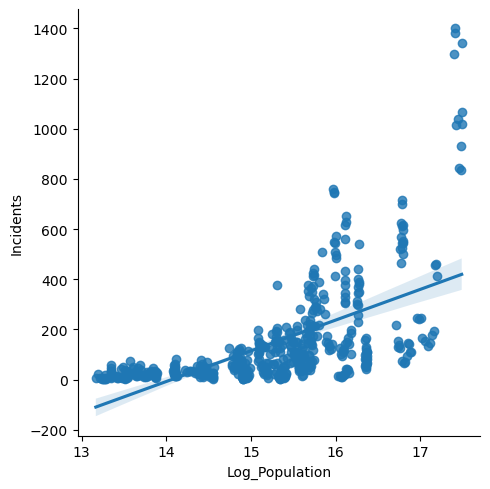

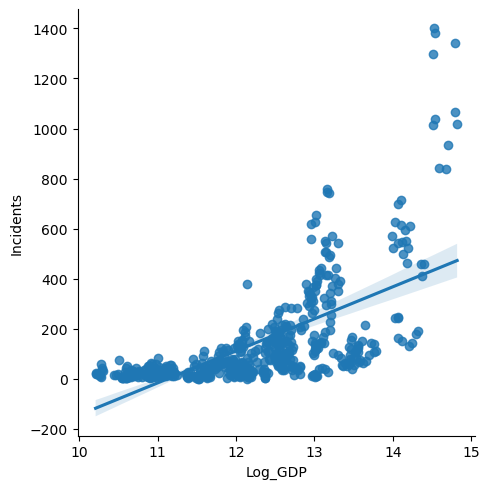

In [87]:
var = train.columns[[9,10]]
for v in var:
    sns.lmplot(data=train, x=v, y='Incidents')
    plt.show()

**Linearity check** We used scatter plots to check the linear relationship between the predictors and response variables. After we created the scatter plots, we recognized that the plots for population and GDP are non-linear. This means that these two predictors failed to meet the linearity assumption. Therefore, we decided to transform these predictors by taking the logarithm of these predictors before we fit them into our multilinear regression model. In future analysis, the population and GDP we referred to are actually log population and log GDP.

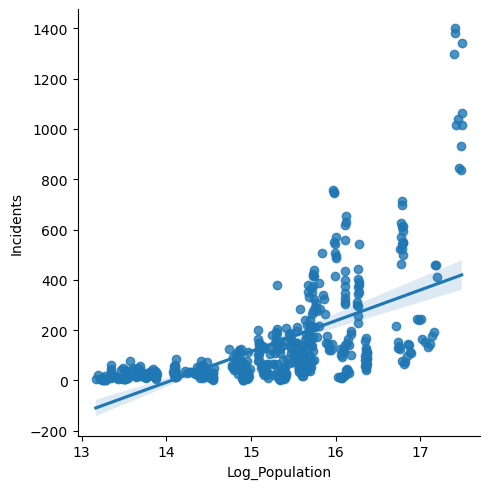

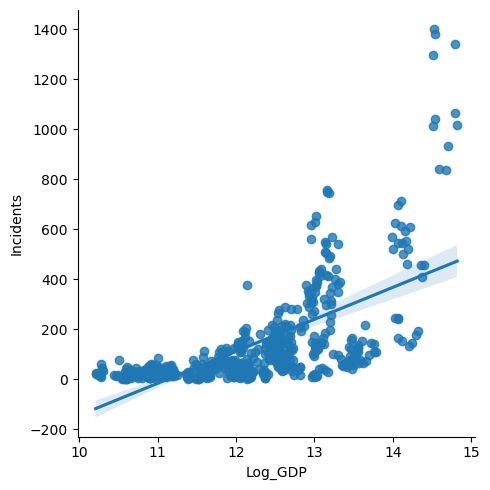

In [88]:
var = train.columns[[9,10]]
for v in var:
    sns.lmplot(data=train, x=v, y='Incidents')
    plt.show()

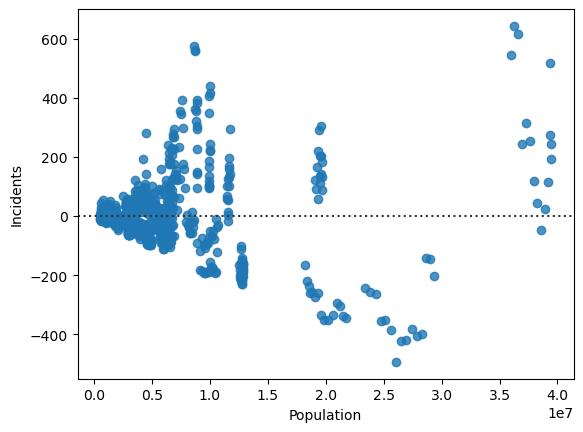

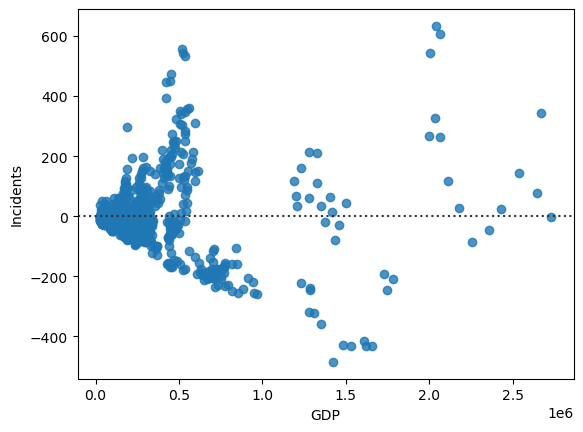

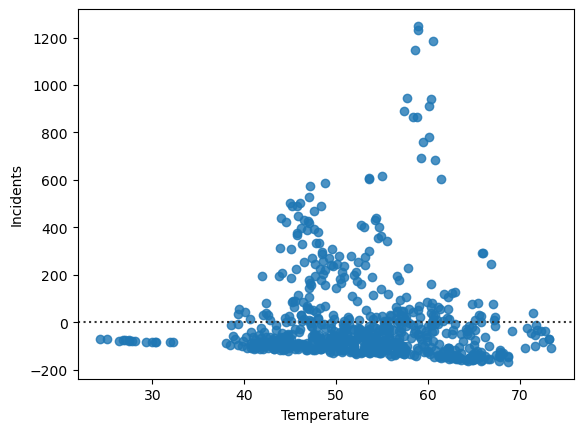

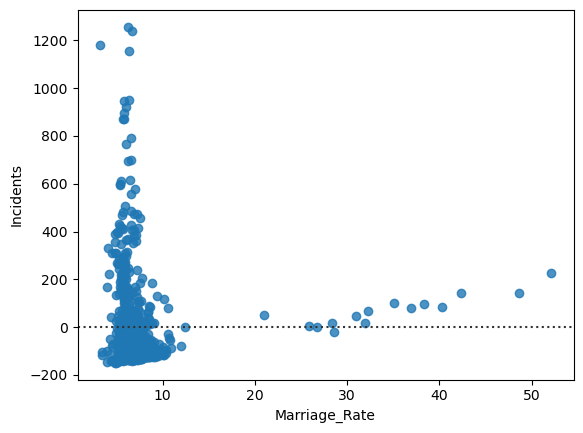

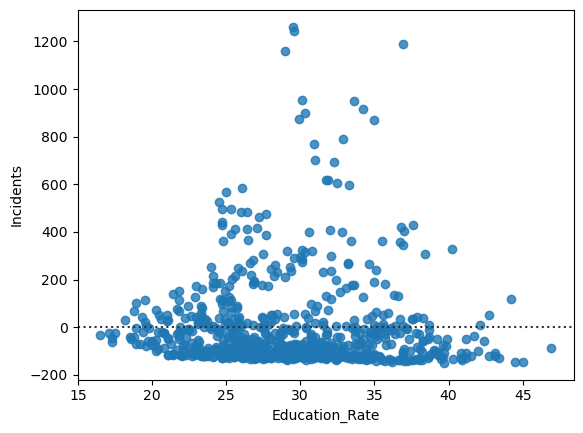

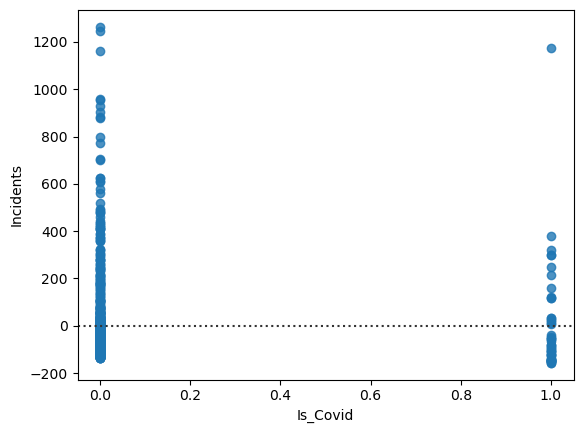

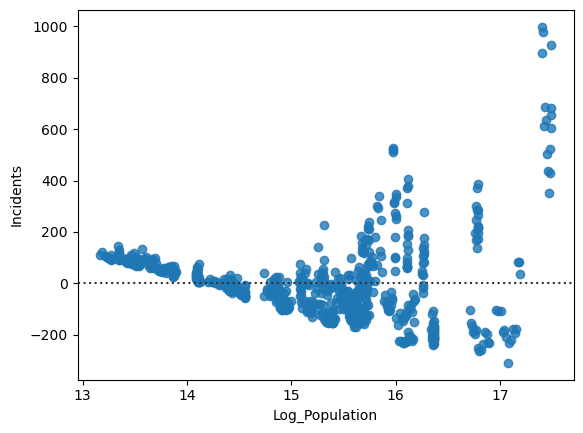

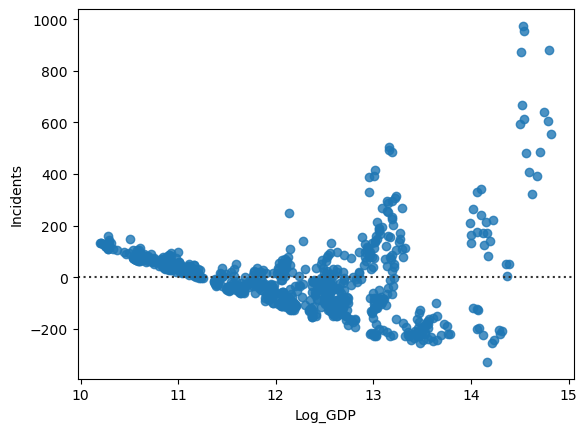

In [89]:
train, test= train_test_split(df, test_size=0.25)
var = train.columns[[2,3,5,6,7,8,9,10]]
for v in var:
    # sns.residplot(data=df, x='Year', y=v)
    sns.residplot(data=df, x=v, y='Incidents')
    plt.show()

**Homoscedasticity check** We created a residual plot for each of the predictors to check homoscedasticity. The results show that the residual plots for population and GDP have an abnormal shape (parabola-like shape). This means that there’s heteroskedasticity between the response variables and each of the two predictors. Therefore, we transformed both predictors by taking the logarithm of the two predictors. The residual plots for the transformed predictors appear to be normal (no abnormal shape that suggests heteroskedasticity).

In [90]:
df.iloc[:,5:].corr()

,Temperature,Marriage_Rate,Education_Rate,Is_Covid,Log_Population,Log_GDP
Temperature,1.000000,-0.019585,-0.172536,0.029190,0.521346,0.443209
Marriage_Rate,-0.019585,1.000000,-0.084587,-0.096028,-0.120524,-0.137006
Education_Rate,-0.172536,-0.084587,1.000000,0.230002,-0.127990,-0.084375
Is_Covid,0.029190,-0.096028,0.230002,1.000000,0.009529,0.016853
Log_Population,0.521346,-0.120524,-0.127990,0.009529,1.000000,0.983259
Log_GDP,0.443209,-0.137006,-0.084375,0.016853,0.983259,1.000000


**Multicollinearity check** We used the correlation coefficient matrix to check for multicollinearity. The results show that there is a high positive correlation between log GDP and log population. The correlation coefficient between the two predictors is 0.981931, which is very close to one. Since there is a very high positive correlation between GDP and population, we should consider dropping one of the two predictors before we fit our multilinear regression model. By looking at the correlation coefficient matrix, we recognized that the population has the most coefficients with high absolute values. This means that the predictor is highly correlated with other predictor variables, so we decided to **drop the population predictor** before we run the multiple linear regression model.

### Data analysis & Evaluation of significance

### Hypothesis 1

Null: None of the predictor variables is useful in terms of predicting the number of state-wise hate crime incidents.

Alternative: At least one of the predictor variables is useful in terms of predicting the number of state-wise hate crime incidents.


**1.1 Determine the best one-variable model**

**Methods**
We conducted *ANOVA F-test* for single variable selection, and verified the results with *T-test in OLS regression*. 

In [91]:
var = ['Temperature', 'Log_GDP', 'Marriage_Rate', 'Education_Rate']
inc = train['Incidents']

# Anova F test for single variable selection
def anova(var):
    f = 'Incidents ~ ' + var
    d = smf.ols(formula=f, data=train)
    model = d.fit()
    a = sm.stats.anova_lm(model)
    print(a)

In [92]:
for v in var: anova(v)

                df        sum_sq        mean_sq        F   PR(>F)
Temperature    1.0  1.890950e+05  189094.962869  4.78229  0.02918
Residual     543.0  2.147058e+07   39540.670118      NaN      NaN
             df        sum_sq       mean_sq           F        PR(>F)
Log_GDP     1.0  8.901437e+06  8.901437e+06  378.851598  2.084443e-64
Residual  543.0  1.275824e+07  2.349584e+04         NaN           NaN
                  df        sum_sq        mean_sq         F  PR(>F)
Marriage_Rate    1.0  3.896580e+05  389657.993836  9.947536  0.0017
Residual       543.0  2.127002e+07   39171.309103       NaN     NaN
                   df        sum_sq       mean_sq         F    PR(>F)
Education_Rate    1.0  7.162036e+04  71620.356732  1.801452  0.180098
Residual        543.0  2.158806e+07  39757.013775       NaN       NaN


**Analysis**
We first ran ANOVA F-tests on each of the four single-predictor models (X=’Log_GDP’ / ‘Temperature’ / ‘Marriage Rate’ / ‘Education Rate’, y=’Incidents’), since F-stats shows their improvement in significance compared to the intercept-only (null) model. The results show that ’Log_GDP’, ‘Temperature’, and ‘Marriage Rate’ have a p-value less than 0.05, which is significant; among these predictors, log GDP has the smallest p-value, which is 7.04-68. Therefore, we choose log GDP as the input of our one-variable model.

In [93]:
# Regression summary including coefficients and p-values
def summary(df, input):
    X = df[input]
    reg = sm.OLS(df['Incidents'], X).fit()
    print(reg.summary())

In [94]:
summary(train, ['Log_GDP'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.370
Model:                            OLS   Adj. R-squared (uncentered):              0.369
Method:                 Least Squares   F-statistic:                              319.4
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                    1.53e-56
Time:                        17:09:59   Log-Likelihood:                         -3638.2
No. Observations:                 545   AIC:                                      7278.
Df Residuals:                     544   BIC:                                      7283.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [95]:
summary(test, ['Log_GDP'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.405
Model:                            OLS   Adj. R-squared (uncentered):              0.401
Method:                 Least Squares   F-statistic:                              122.9
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                    3.91e-22
Time:                        17:09:59   Log-Likelihood:                         -1206.7
No. Observations:                 182   AIC:                                      2415.
Df Residuals:                     181   BIC:                                      2419.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Evaluation of significance**

For our model with log GDP as predictor, we ran t-test in OLS regression for verification. We got p-values less than 0.05 for both training and testing sets, which are significant results. Therefore, we confirm that our choice of **log GDP is significant** to predict hate crime incidents, and **log GDP is our best single predictor**.

**1.2 Determine the combination of more than one predictors that best predicts the hate crime incidents.** 

**Methods** We conducted step-wise model selection by using Log Likelihood Ratio test, and then use OLS regression to check the model.

- On top of the best one-predictor model, we ran log likelihood ratio tests to determine if we can improve it by adding one more predictor. We iterated this process from raising one predictor to two, two predictors to three, and finally three predictors to four, until we found the optimal combination of predictors for the model. 
 
- In our case, the log likelihood ratio tests if the performance of our previously selected model changes significantly before and after adding one parameter. Specifically, we compare the best model so far (with variables selected from previous tests) and a new model in which we added a new variable. If the p-value of log likelihood ratio is less than 0.5, which is a significant difference, we argue that adding this variable has the potential to improve the model’s goodness of fit. After selecting a new model, we iterated this process by introducing another predictor, and deciding whether to include it until we found the best combination of inputs.

- After running the Log Likelihood Ratio test, we ran OLS regression on the model with the selected predictors to verify that each input in our newly-selected model has a significant effect on the output (p < 0.05). If all input has p-values less than .05, we confirm that the newly-selected model is the best model so far.
the additional one variable we selected has the most significance in improving model performance.

***1.2.1 From one-predictor to two-predictors model***

In [96]:
# Log likelihood ratio test for further models selection
def llr(base, add):
    X = train[add]
    model = sm.OLS(inc, X).fit()
    likelihood_ratio = -2*(base.llf - model.llf)
    log_likelihood_ratio = scipy.stats.chi2.sf(likelihood_ratio, 2)
    print(str(add) +'LLR = '+ str(log_likelihood_ratio))

In [97]:
g = sm.OLS(inc, train['Log_GDP']).fit()
llr(g, ['Log_GDP', 'Temperature'])
llr(g, ['Log_GDP', 'Marriage_Rate'])
llr(g, ['Log_GDP', 'Education_Rate'])

['Log_GDP', 'Temperature']LLR = 5.94118560995029e-10
['Log_GDP', 'Marriage_Rate']LLR = 1.1294121842472602e-06
['Log_GDP', 'Education_Rate']LLR = 7.319679280481226e-05


**Analysis** 

We tested three possible two-predictors models by using the log likelihood ratio test. The results show that adding a second predictor to our best one-predictor model (X = log GDP) does improve the model’s goodness of fit. The p-values for all three possible two-predictors models are less than 0.05. However, the model with **log GDP and temperature** is the two-predictors model with the lowest p-value, which is 5.94e-10. Thus we selected his two-predictors model as our new best model. 

In [98]:
summary(train, ['Log_GDP', 'Temperature'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.417
Model:                            OLS   Adj. R-squared (uncentered):              0.415
Method:                 Least Squares   F-statistic:                              194.3
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                    2.20e-64
Time:                        17:09:59   Log-Likelihood:                         -3617.0
No. Observations:                 545   AIC:                                      7238.
Df Residuals:                     543   BIC:                                      7247.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [99]:
summary(test, ['Log_GDP', 'Temperature'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.459
Model:                            OLS   Adj. R-squared (uncentered):              0.453
Method:                 Least Squares   F-statistic:                              76.21
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                    1.05e-24
Time:                        17:09:59   Log-Likelihood:                         -1198.0
No. Observations:                 182   AIC:                                      2400.
Df Residuals:                     180   BIC:                                      2406.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

**Evaluation of significance** 

We also ran the OLS regression that fits a regression model on log GDP and temperature for both testing and training data. The results show that the p-values are less than 0.05,  which means the predictors in the current two-predictors model are statistically significant. This confirms that the model with inputs **(X = log GDP + Temperature)** is better than the previous model and we should include both inputs. 

***1.2.2 From two-predictor to three-predictors model***

In [100]:
gt = sm.OLS(inc, train[['Log_GDP', 'Temperature']]).fit()
llr(gt, ['Log_GDP', 'Temperature', 'Marriage_Rate'])
llr(gt, ['Log_GDP', 'Temperature', 'Education_Rate'])

['Log_GDP', 'Temperature', 'Marriage_Rate']LLR = 6.515220089666822e-06
['Log_GDP', 'Temperature', 'Education_Rate']LLR = 2.0708856956296244e-06


**Analysis** We tested the two possible three-predictors models by using the log likelihood ratio test. The results show that adding a third predictor to our best two-predictors model (hate crime incidents modeled by log GDP and temperature) does improve the model’s goodness of fit. The p-values for all two possible two-predictors models are less than 0.05. However, the model with **log GDP, temperature, and education rate** is has the lowest p-value, which is 2.07e-06. This three-predictors model is our new best model.

In [101]:
summary(train, ['Log_GDP', 'Temperature', 'Education_Rate'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.445
Model:                            OLS   Adj. R-squared (uncentered):              0.441
Method:                 Least Squares   F-statistic:                              144.6
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                    7.99e-69
Time:                        17:09:59   Log-Likelihood:                         -3603.9
No. Observations:                 545   AIC:                                      7214.
Df Residuals:                     542   BIC:                                      7227.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [102]:
summary(test, ['Log_GDP', 'Temperature', 'Education_Rate'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.497
Model:                            OLS   Adj. R-squared (uncentered):              0.488
Method:                 Least Squares   F-statistic:                              58.88
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                    1.57e-26
Time:                        17:09:59   Log-Likelihood:                         -1191.4
No. Observations:                 182   AIC:                                      2389.
Df Residuals:                     179   BIC:                                      2398.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

**Evaluation of significance** We also ran the OLS regression that fits the regression model on the three predictors **(log GDP, temperature, and education rate)** for both test and training data. The results show that the p-value is less than 0.05, which confirms our choice of model. Thus, the predictors in the current three-predictors model are statistically significant.

***1.2.3 From three-predictor to four-predictors model***

In [103]:
gte = sm.OLS(inc, train[['Log_GDP', 'Temperature', 'Education_Rate']]).fit()
llr(gte, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate'])

['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate']LLR = 1.936302077239067e-05


**Analysis**
We tested the four-predictors models by using the log likelihood ratio test. The results show that adding a four predictor to our best three-predictors model (hate crime incidents modeled by log GDP, temperature, and education rate) does improve the model’s goodness of fit. The p-value for the four-predictors model is less than 0.05. This means that the fours-predictors model became our new best model.


In [104]:
summary(train, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.466
Model:                            OLS   Adj. R-squared (uncentered):              0.462
Method:                 Least Squares   F-statistic:                              118.1
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                    2.30e-72
Time:                        17:09:59   Log-Likelihood:                         -3593.1
No. Observations:                 545   AIC:                                      7194.
Df Residuals:                     541   BIC:                                      7211.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [105]:
summary(test, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.508
Model:                            OLS   Adj. R-squared (uncentered):              0.497
Method:                 Least Squares   F-statistic:                              45.89
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                    1.89e-26
Time:                        17:09:59   Log-Likelihood:                         -1189.4
No. Observations:                 182   AIC:                                      2387.
Df Residuals:                     178   BIC:                                      2400.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

**Evaluation of significance** 

We also ran the OLS regression that fits the regression model on the four predictors **(log GDP, temperature, education rate, and marriage rate)** for both test and training data. The results show that the p-value is less than 0.05, which confirms our choice of model. Since we have no more predictors to consider, this four-predictors model is our final best model.

### Hypothesis 2

Null: On top of the model above, before Covid or after doesn’t affect the number of state-wise hate crime incidents.

Alternative: Incidents of state-wise hate crimes increase with the presence of Covid.

In [106]:
gtme = sm.OLS(inc, train[['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate']]).fit()
llr(gtme, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid'])

['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid']LLR = 0.11398231401326082


We determine the significance of is_covid using the log likelihood ratio test. The results show that adding a is_covid to our best four-predictors model does NOT improve the model’s goodness of fit. The p-value for the model containing is_covid is 0.114 larger than 0.05. This means that the **is_covid help does NOT help** improving the performance and significance of our model in predicitng hate crime incidents. 

In [107]:
summary(train, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.470
Model:                            OLS   Adj. R-squared (uncentered):              0.466
Method:                 Least Squares   F-statistic:                              95.94
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                    3.14e-72
Time:                        17:09:59   Log-Likelihood:                         -3590.9
No. Observations:                 545   AIC:                                      7192.
Df Residuals:                     540   BIC:                                      7213.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [108]:
summary(test, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.508
Model:                            OLS   Adj. R-squared (uncentered):              0.494
Method:                 Least Squares   F-statistic:                              36.51
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                    1.36e-25
Time:                        17:09:59   Log-Likelihood:                         -1189.4
No. Observations:                 182   AIC:                                      2389.
Df Residuals:                     177   BIC:                                      2405.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

**Evaluation of significance** To verify, we also ran the OLS regression that fits the regression model on the five predictors including is_covid for both test and training data. The results show that the p-value for is_covid is 0.712, larger than 0.05, and thus is not significant. This means that the **is_covid help does NOT help** improving the performance and significance of our model in predicitng hate crime incidents. 

### Interpretation and Conclusions

**Hypothesis 1** 
- Of all our potential predictor candidates, including **log GDP, temperature, education rate, and marriage rate** as inputs is the best combination to predict hate crime incidents. 
- βi ≠ 0 (for i = log GDP, log population, temperature, marriage rate, education rate). All p-values are less than 0.05.

**Interpretation**
- Summary:
  - When GDP increases 1 million dollars, hate crime increases 66 incidents.
  - When Year Average Temperature increases 1 Fahrenheit, hate crime decreases 8 incidents.
  - When Education Rate increases 1 %, hate crime decreases 7 incidents.
  - When Marriage increases 1 unit, hate crime decreases 4 incidents.
  
- Prediction: 
  - Vermont at 2020 when 
  - GDP = 29064.6 million dollars, 
  - Year Average Temperature = 44.8 Fahrenheit, 
  - Marriage Rate = 6.0%, 
  - Education Rate = 42.0%, 
  - hate crime incidents is predicted to be 51.16, while the actual incidents number is 60.
- Oddities: 
  - Hate crime incidents should be integers in real world, but our predictions are floats.
  - Hate crime incidents should be all positive in real world, but we sometimes get negative prediction results.


**Hypothesis 2**

- **Covid status help does NOT help** improving the model in predicitng hate crime incidents. 
-  β(is_covid) ≠ 0 but its p-value is larger than 0.05. 


### Limitations
- Our study should not be used to provide hate crime offenders with justification for their crime commitments.
- We lack domian expertise to select optimal variables to predict hate crime incidents. Although our significance is in acceptable range, the accurarcy may still has space to improve.

Questions:
1. What EDA graphs should we include  (do we need more)?
2. Is it acceptable to the lower p-value of log likelihood ratio as a better model?
3. Should we conduct further State-wise and Year-wise analysis?
4. Should we check the feasibility assumptions of multiple variable linear regression in each step?